# Demonstrate Interface with Battery Toolkit
Moirae provides utility operations for estimating the state of health given battery data stored in HDF5 files with the [Battery Data Toolkit[(https://github.com/ROVI-org/battery-data-toolkit) and 
storing the results back into an HDF5 file for convenient organization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.estimators.online.joint import JointEstimator
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity, ReferenceOCV
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput
from moirae.interface import run_online_estimate
from batdata.data import BatteryDataset
from shutil import copyfileobj
from pathlib import Path
import numpy as np
import requests
import h5py

Configuration

In [2]:
data_url = 'https://github.com/ROVI-org/battery-data-toolkit/raw/refs/heads/main/tests/files/example-data/single-resistor-complex-charge_from-discharged.hdf'
data_dir = Path('data')

In [3]:
data_dir.mkdir(exist_ok=True)

## Download and Parse the Data
Download the data using HTTP and store locally

In [4]:
data_path = data_dir / data_url.split("/")[-1]
print(f'Saving data to {data_path}')

Saving data to data\single-resistor-complex-charge_from-discharged.hdf


Download if not present

In [5]:
if not data_path.exists():
    with data_path.open('wb') as fp:
        copyfileobj(requests.get(data_url, stream=True).raw, fp)

In [6]:
dataset = BatteryDataset.from_batdata_hdf(data_path)

C:\Users\lward\Work\ROVI\battery-data-toolkit\batdata\data.py:90: UserWarning: Metadata was created in a different version of batdata. supplied=0.2.0, current=0.3.2.
  warnings.warn(f'Metadata was created in a different version of batdata. supplied={supplied_version}, current={__version__}.')


In [7]:
dataset.metadata.model_dump(exclude_defaults=True)

{'version': '0.2.0'}

This dataset contains a single cycle of battery data made using a simple battery model.

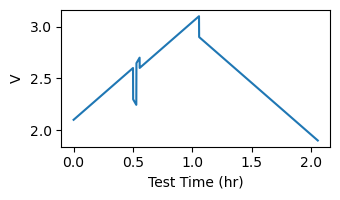

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(dataset.raw_data['test_time'] / 3600, dataset.raw_data['voltage'])

ax.set_xlabel('Test Time (hr)')
ax.set_ylabel('V')
fig.tight_layout()

## Create a ECM Model
Our goal isn't to demonstrate the effectiveness of state estimation, so I'm going to build a model using [the known parameters](https://github.com/ROVI-org/battery-data-toolkit/blob/main/tests/files/example-data/resistor-only_complex-cycling.ipynb).

In [9]:
asoh = ECMASOH(
    q_t=MaxTheoreticalCapacity(base_values=1.),
    r0=Resistance(base_values=0.1),
    ocv=OpenCircuitVoltage(
        ocv_ref=ReferenceOCV(base_values=[2., 3.]),
        ocv_ent={'base_values': 0}
    )
)
asoh.mark_updatable('r0.base_values')

In [10]:
ecm_start = ECMTransientVector(soc=0., hyst=0.)

## Run Estimation Using Historical Data
The [`run_online_estimation`](https://rovi-org.github.io/auto-soh/source/interface.html#moirae.interface.run_online_estimate) performs online state estimation using
all data available in a battery dataset.
By default, it returns the states estimated at each step in memory.

In [11]:
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=asoh,
    initial_inputs=ECMInput(time=0., current=-1., temperature=25),
    initial_transients=ecm_start,
    covariance_joint=np.diag([0.02, 0.0001, 0.01])  # Three variables: soc, hysteresis, r0
)

In [12]:
%%time
states, _ = run_online_estimate(dataset, ukf, pbar=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [00:04<00:00, 880.97it/s]

CPU times: total: 562 ms
Wall time: 4.21 s


In [13]:
states

,soc,hyst,r0.base_values,soc_std,hyst_std,r0.base_values_std,terminal_voltage,terminal_voltage_std
0,0.132890,0.000665,0.033555,0.006711,0.000100,0.006678,1.900000,3.010004e-02
1,0.132705,0.000887,0.033259,0.006711,0.000100,0.006678,2.099444,5.000000e-08
2,0.132519,0.001221,0.032907,0.006711,0.000100,0.006678,2.099778,4.800000e-08
3,0.132334,0.001583,0.032541,0.006711,0.000100,0.006678,2.100278,4.791667e-08
4,0.132149,0.001952,0.032171,0.006711,0.000100,0.006678,2.100821,4.791304e-08
...,...,...,...,...,...,...,...,...
3696,0.496879,0.170470,-0.764834,0.000122,0.000122,0.000012,1.903626,4.791288e-08
3697,0.497064,0.170100,-0.765204,0.000122,0.000122,0.000012,1.903071,4.791288e-08
3698,0.497249,0.169729,-0.765575,0.000122,0.000122,0.000012,1.902515,4.791288e-08
3699,0.497434,0.169359,-0.765945,0.000122,0.000122,0.000012,1.901960,4.791288e-08


The states are not large in this example, but you can imagine that estimating models with many parameters over long periods will gradually outstrip available memory.

## Run Estimate and Stream Results to Disk
Stream results to disk by, at least, supplying the Path to an output HDF5 file. Turn off storing the states in memory too by setting `output_states=False`

In [14]:
output_file = Path('data') / 'interface-demo.hdf5'
output_file.unlink(missing_ok=True)

In [15]:
%%time
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ecm_start,
    covariance_joint=np.diag([0.02, 0.0001, 0.01])  # Three variables: soc, hysteresis, r0
)
states, _ = run_online_estimate(dataset, ukf, hdf5_output=output_file, output_states=False, pbar=True)
assert states is None  # Look, we skipped output it

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [00:08<00:00, 429.71it/s]

CPU times: total: 1.78 s
Wall time: 8.63 s


This file contains a summary of the estimates produced from the state estimator in a group named "state_estimates" (by default).

In [16]:
file = h5py.File(output_file)
group = file['state_estimates']
group

<HDF5 group "/state_estimates" (2 members)>

That group contains metadata about how the estimates were produced

In [17]:
for k, v in group.attrs.items():
    print(f'{k}: "{v[:32]}{"..." if len(v) > 32 else ""}"')

cell_model: "EquivalentCircuitModel"
distribution_type: "MultivariateGaussian"
estimator_name: "JointEstimator"
initial_asoh: "{"updatable":["r0"],"q_t":{"upda..."
initial_transient_state: "{"soc":[[0.0]],"q0":null,"i_rc":..."
output_names: "['terminal_voltage']"
state_names: "['soc' 'hyst' 'r0.base_values']"
write_settings: "{"file_options":{"rdcc_nbytes":1..."


And the estimates themselves for both every step

In [18]:
for g in ['per_cycle', 'per_timestep']:
    print(group[g])
    for k, v in group[g].items():
        print(f'  {k}: {v.shape}')

<HDF5 group "/state_estimates/per_cycle" (5 members)>
  output_covariance: (1, 1, 1)
  output_mean: (1, 1)
  state_covariance: (1, 3, 3)
  state_mean: (1, 3)
  time: (1,)
<HDF5 group "/state_estimates/per_timestep" (3 members)>
  output_mean: (3701, 1)
  state_mean: (3701, 3)
  time: (3701,)


In [19]:
file.close()

The default is to store the full probability distribution for the first step of each cycle and only the means at each step.

The `read_state_estimates` reads these probability distributions as Moirae's probability distribution objects

In [20]:
from moirae.interface.hdf5 import read_state_estimates

In [21]:
next(read_state_estimates(output_file, per_timestep=True))

(0.0,
 DeltaDistribution(mean=array([0.13289026, 0.00066452, 0.03355484])),
 DeltaDistribution(mean=array([1.9])))

In [22]:
next(read_state_estimates(output_file, per_timestep=False))

(0.0,
 MultivariateGaussian(mean=array([0.13289026, 0.00066452, 0.03355484]), covariance=array([[ 6.71097783e-03, -6.64517722e-05,  6.64451941e-03],
        [-6.64517722e-05,  9.96777081e-05,  3.32259027e-05],
        [ 6.64451941e-03,  3.32259027e-05,  6.67774863e-03]])),
 MultivariateGaussian(mean=array([1.9]), covariance=array([[0.03010004]])))

The function returns an iterator which reads data from the file into memory only as needed.
Access data incrementally with `next` or with a for loop

In [23]:
%%time
for time, state_dist, output_dist in read_state_estimates(output_file, per_timestep=True):
    pass

CPU times: total: 78.1 ms
Wall time: 497 ms


## Controlling the Outputs
Supplying a path to the `run_online_estimate` function writes an HDF file with the above-described defaults and reasonable settings for how the HDF5 file is written (small I/O caches, moderate compression).
Change how the estimates are written by supplying a `HDF5Writer` class

In [24]:
from moirae.interface.hdf5 import HDF5Writer

In [25]:
output_file.unlink(missing_ok=True)
writer = HDF5Writer(
    hdf5_output=output_file,
    per_cycle='none',
    per_timestep='mean_var',
    dataset_options={'compression': None},
)

In [26]:
%%time
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ecm_start,
    covariance_joint=np.diag([0.02, 0.0001, 0.01])  # Three variables: soc, hysteresis, r0
)
run_online_estimate(dataset, ukf, hdf5_output=writer, output_states=False, pbar=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [00:07<00:00, 484.60it/s]

CPU times: total: 1.84 s
Wall time: 7.65 s


Note how the process is slightly faster and produces a data file with different content

In [27]:
with h5py.File(output_file, mode='a') as file:
    group = file['state_estimates']
    for g in ['per_cycle', 'per_timestep']:
        sg = group.require_group(g)
        print(sg)
        for k, v in sg.items():
            print(f'  {k}: {v.shape}')

<HDF5 group "/state_estimates/per_cycle" (0 members)>
<HDF5 group "/state_estimates/per_timestep" (5 members)>
  output_mean: (3701, 1)
  output_variance: (3701, 1)
  state_mean: (3701, 3)
  state_variance: (3701, 3)
  time: (3701,)


Consult the documentation for [`HDF5Writer`](https://rovi-org.github.io/auto-soh/source/interface.html#moirae.interface.hdf5.HDF5Writer) for a full description of options.